# Import data and stuff

In [1]:
from sklearn.linear_model import LinearRegression
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.preprocessing import normalize, StandardScaler, MinMaxScaler
import seaborn as sns

In [6]:
data_df = pd.read_csv('./run2.csv')
data_df = data_df[data_df["speed_avg"] < 600]
data_df = data_df[["duty_cycle","speed_avg"]]
X = data_df.to_numpy()

In [7]:
data_df.corr()

,duty_cycle,speed_avg
duty_cycle,1.000000,0.869815
speed_avg,0.869815,1.000000


In [8]:
data_df

,duty_cycle,speed_avg
0,47,246.428158
1,45,259.895864
2,42,270.464729
3,42,281.724724
4,41,301.669997
...,...,...
4005,100,530.234599
4006,100,537.594669
4007,100,537.241391
4008,100,534.906953


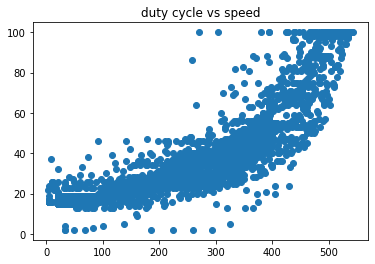

In [9]:
plt.figure()
plt.title("duty cycle vs speed")
plt.scatter(X[:,1],X[:,0]);

Given this correlation, `duty_cycle` and `speed_avg` are well correlated, but not perfectly.

In [10]:
linreg = LinearRegression()
voltage = X[:,0].reshape(-1,1)
speed = X[:,1].reshape(-1,1)
linreg.fit(speed,voltage)
predicted_voltage = linreg.predict(speed)
linreg.score(speed,voltage)

0.7565777246563734

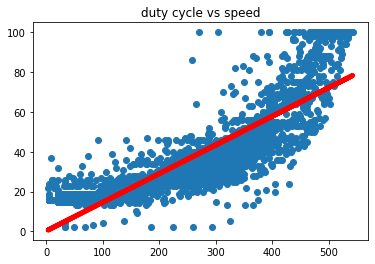

In [11]:
plt.figure()
plt.title("duty cycle vs speed")
plt.scatter(speed,voltage)
plt.plot(speed,predicted_voltage,color="red",linewidth=5.0);

In [12]:
np.sqrt(np.mean((predicted_voltage-voltage)**2))

10.790383704548834

In [13]:
speed_scaler = MinMaxScaler()
speed_scaler.fit(speed)
speed_scaled = speed_scaler.transform(speed)

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2022-04-13 10:27:55.398061: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-13 10:27:55.398117: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [15]:
model = keras.Sequential(
    [
        keras.Input(shape=(1,)),
        layers.Dense(12, activation="sigmoid", name="layer1"),
        layers.Dense(1, name='out', activation='sigmoid')
    ]
)
model.summary()
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='mean_squared_error', optimizer=opt)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 12)                24        
                                                                 
 out (Dense)                 (None, 1)                 13        
                                                                 
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


2022-04-13 10:27:58.943319: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-13 10:27:58.943461: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-13 10:27:58.943525: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (penguin): /proc/driver/nvidia/version does not exist
2022-04-13 10:27:58.943883: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
model.fit(speed_scaled, voltage / 100, epochs=1000)

Epoch 1/1000
125/125 [==============================] - 1s 1ms/step - loss: 0.0423
Epoch 2/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0185
Epoch 3/1000
125/125 [==============================] - 0s 2ms/step - loss: 0.0110
Epoch 4/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0106
Epoch 5/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0102
Epoch 6/1000
125/125 [==============================] - 0s 2ms/step - loss: 0.0100
Epoch 7/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0097
Epoch 8/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0096
Epoch 9/1000
125/125 [==============================] - 0s 2ms/step - loss: 0.0094
Epoch 10/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0092
Epoch 11/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0091
Epoch 12/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0089
E

125/125 [==============================] - 0s 1ms/step - loss: 0.0056
Epoch 99/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0056
Epoch 100/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0056
Epoch 101/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0056
Epoch 102/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0056
Epoch 103/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0056
Epoch 104/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0056
Epoch 105/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0056
Epoch 106/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0056
Epoch 107/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0056
Epoch 108/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0057
Epoch 109/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0

KeyboardInterrupt: 

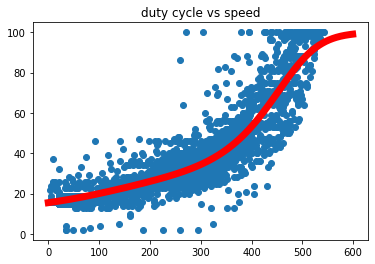

In [17]:
test_a = speed_scaler.transform(np.array(range(600)).reshape(-1,1))
predicted_voltage = model.predict(test_a) * 100
# Y = min_max_scaler_b.inverse_transform(Y_scaled)

plt.figure()
plt.title("duty cycle vs speed")
plt.scatter(speed,voltage)
plt.plot(np.array(range(600)).reshape(-1,1),predicted_voltage,color="red",linewidth=7.0);

In [18]:
predicted_voltage = model.predict(speed_scaler.transform(speed)) * 100
np.sqrt(np.mean((predicted_voltage-voltage)**2))

7.413299822809325

Slightly better.

# With acceleration

In [20]:
data_df = pd.read_csv('./run2.csv')
data_df = data_df[data_df["speed_avg"] < 600]
data_df = data_df[["duty_cycle","acc","speed_avg"]]
X = data_df.to_numpy()

In [21]:
linreg = LinearRegression()
voltage = X[:,0].reshape(-1,1)
X_actual = X[:,1:]
linreg.fit(X_actual,voltage)
predicted_voltage = linreg.predict(X_actual)
linreg.score(X_actual,voltage)

0.7583845405246178

In [22]:
np.sqrt(np.mean((predicted_voltage-voltage)**2))

10.750262993837906

In [23]:
model = keras.Sequential(
    [
        keras.Input(shape=(2,)),
        layers.Dense(12, activation="sigmoid", name="layer1"),
        layers.Dense(1, name='out', activation='sigmoid')
    ]
)
model.summary()
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='mean_squared_error', optimizer=opt)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 12)                36        
                                                                 
 out (Dense)                 (None, 1)                 13        
                                                                 
Total params: 49
Trainable params: 49
Non-trainable params: 0
_________________________________________________________________


In [24]:
X_scaler = MinMaxScaler()
X_scaler.fit(X_actual)
X_scaled = X_scaler.transform(X_actual)

In [25]:
model.fit(X_scaled, voltage / 100, epochs=1000)

Epoch 1/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0378
Epoch 2/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0157
Epoch 3/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0110
Epoch 4/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0105
Epoch 5/1000
125/125 [==============================] - 0s 3ms/step - loss: 0.0103
Epoch 6/1000
125/125 [==============================] - 0s 3ms/step - loss: 0.0100
Epoch 7/1000
125/125 [==============================] - 0s 2ms/step - loss: 0.0100
Epoch 8/1000
125/125 [==============================] - 0s 2ms/step - loss: 0.0097
Epoch 9/1000
125/125 [==============================] - 0s 2ms/step - loss: 0.0095
Epoch 10/1000
125/125 [==============================] - 0s 2ms/step - loss: 0.0093
Epoch 11/1000
125/125 [==============================] - 0s 2ms/step - loss: 0.0097
Epoch 12/1000
125/125 [==============================] - 0s 2ms/step - loss: 0.0092
E

125/125 [==============================] - 0s 1ms/step - loss: 0.0056
Epoch 99/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0056
Epoch 100/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0056
Epoch 101/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0056
Epoch 102/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0056
Epoch 103/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0057
Epoch 104/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0055
Epoch 105/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0056
Epoch 106/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0055
Epoch 107/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0056
Epoch 108/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0057
Epoch 109/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0

125/125 [==============================] - 0s 1ms/step - loss: 0.0054
Epoch 195/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0054
Epoch 196/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0053
Epoch 197/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0053
Epoch 198/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0054
Epoch 199/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0053
Epoch 200/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0054
Epoch 201/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0053
Epoch 202/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0053
Epoch 203/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0053
Epoch 204/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.0053
Epoch 205/1000
125/125 [==============================] - 0s 1ms/step - loss: 0.

KeyboardInterrupt: 

In [26]:
predicted_voltage = model.predict(X_scaled) * 100
np.sqrt(np.mean((predicted_voltage-voltage)**2))

7.267707686930133

A tiny bit better now.

# Basic RNN

In [29]:
data_df = pd.read_csv('./run2.csv')
data_df = data_df[data_df["speed_avg"] < 600]
data_df = data_df[["ts","duty_cycle","acc","speed_avg"]]
X = data_df.to_numpy()

In [30]:
data_df

,ts,duty_cycle,acc,speed_avg
0,1649720766813,47,1.254785,246.428158
1,1649720766846,45,1.091950,259.895864
2,1649720766879,42,-0.181992,270.464729
3,1649720766913,42,-0.507661,281.724724
4,1649720766946,41,-1.254785,301.669997
...,...,...,...,...
4005,1649720965510,100,-0.747124,530.234599
4006,1649720965543,100,-0.977008,537.594669
4007,1649720965577,100,-0.747124,537.241391
4008,1649720965610,100,0.488504,534.906953


In [31]:
timestamps = X[:,0] 

In [32]:
ts_diffs = timestamps[1:] - timestamps[:-1]

In [33]:
N = 5

In [410]:
model = keras.Sequential(
    [
        keras.Input(shape=(N,3)),
        layers.SimpleRNN(8, name="rnnlayer"),
        layers.Dense(8, activation="relu", name="layer2"),
        layers.Dense(1, name='out', activation='sigmoid')
    ]
)
model.summary()
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='mean_squared_error', optimizer=opt)

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rnnlayer (SimpleRNN)        (None, 8)                 96        
                                                                 
 layer2 (Dense)              (None, 8)                 72        
                                                                 
 out (Dense)                 (None, 1)                 9         
                                                                 
Total params: 177
Trainable params: 177
Non-trainable params: 0
_________________________________________________________________


In [34]:
model = keras.models.load_model('best_model_ever.h5')

In [35]:
sequences = []
current_sequence = []

for i, diff in enumerate(ts_diffs):
    if diff < 101:
        current_sequence.append(i)
    else:
        if len(current_sequence) > N * 2:
            sequences.append(current_sequence)
        current_sequence = [i]
        
print(len(sequences))

37


In [36]:
X_relevant = X[:,1:]
Xs_scaler = MinMaxScaler()
Xs_scaler.fit(X_relevant)
X_relevant = Xs_scaler.transform(X_relevant)

In [484]:
# for sequence in sequences:


for sequence in sequences[:]:
    if len(sequence) < 100:
        continue
    Xs = []
    Ys = []
    for n in sequence[N:]:
        indexes_x = np.arange(n-N,n)
        index_y = n
        Ys.append(X[index_y,1])
        Xs.append(X_relevant[indexes_x])
    Xs = np.array(Xs)
    Ys = np.array(Ys).reshape(-1,1)
    model.fit(Xs, Ys/100, epochs=10, batch_size=24, verbose=2)
    
print(Xs.shape, Ys.shape)

Epoch 1/10
6/6 - 0s - loss: 2.7218e-04 - 17ms/epoch - 3ms/step
Epoch 2/10
6/6 - 0s - loss: 2.6074e-04 - 18ms/epoch - 3ms/step
Epoch 3/10
6/6 - 0s - loss: 2.6425e-04 - 25ms/epoch - 4ms/step
Epoch 4/10
6/6 - 0s - loss: 2.2794e-04 - 19ms/epoch - 3ms/step
Epoch 5/10
6/6 - 0s - loss: 3.0873e-04 - 22ms/epoch - 4ms/step
Epoch 6/10
6/6 - 0s - loss: 2.7154e-04 - 21ms/epoch - 3ms/step
Epoch 7/10
6/6 - 0s - loss: 2.0370e-04 - 21ms/epoch - 4ms/step
Epoch 8/10
6/6 - 0s - loss: 1.8354e-04 - 21ms/epoch - 3ms/step
Epoch 9/10
6/6 - 0s - loss: 1.9733e-04 - 22ms/epoch - 4ms/step
Epoch 10/10
6/6 - 0s - loss: 1.6273e-04 - 27ms/epoch - 5ms/step
Epoch 1/10
5/5 - 0s - loss: 1.0611e-04 - 18ms/epoch - 4ms/step
Epoch 2/10
5/5 - 0s - loss: 8.5064e-05 - 19ms/epoch - 4ms/step
Epoch 3/10
5/5 - 0s - loss: 8.8428e-05 - 22ms/epoch - 4ms/step
Epoch 4/10
5/5 - 0s - loss: 8.4224e-05 - 20ms/epoch - 4ms/step
Epoch 5/10
5/5 - 0s - loss: 8.3071e-05 - 19ms/epoch - 4ms/step
Epoch 6/10
5/5 - 0s - loss: 7.8764e-05 - 22ms/epoch - 

Epoch 1/10
5/5 - 0s - loss: 6.8184e-06 - 21ms/epoch - 4ms/step
Epoch 2/10
5/5 - 0s - loss: 6.0504e-06 - 20ms/epoch - 4ms/step
Epoch 3/10
5/5 - 0s - loss: 1.4085e-05 - 16ms/epoch - 3ms/step
Epoch 4/10
5/5 - 0s - loss: 1.1746e-05 - 22ms/epoch - 4ms/step
Epoch 5/10
5/5 - 0s - loss: 1.1123e-05 - 18ms/epoch - 4ms/step
Epoch 6/10
5/5 - 0s - loss: 1.1372e-05 - 17ms/epoch - 3ms/step
Epoch 7/10
5/5 - 0s - loss: 1.0532e-05 - 18ms/epoch - 4ms/step
Epoch 8/10
5/5 - 0s - loss: 9.2295e-06 - 17ms/epoch - 3ms/step
Epoch 9/10
5/5 - 0s - loss: 6.6199e-06 - 18ms/epoch - 4ms/step
Epoch 10/10
5/5 - 0s - loss: 6.2891e-06 - 18ms/epoch - 4ms/step
Epoch 1/10
5/5 - 0s - loss: 3.0735e-04 - 19ms/epoch - 4ms/step
Epoch 2/10
5/5 - 0s - loss: 2.0410e-04 - 21ms/epoch - 4ms/step
Epoch 3/10
5/5 - 0s - loss: 1.8564e-04 - 18ms/epoch - 4ms/step
Epoch 4/10
5/5 - 0s - loss: 1.8145e-04 - 20ms/epoch - 4ms/step
Epoch 5/10
5/5 - 0s - loss: 1.6117e-04 - 19ms/epoch - 4ms/step
Epoch 6/10
5/5 - 0s - loss: 1.6459e-04 - 19ms/epoch - 

In [496]:
len(sequences[8])

122

In [37]:
rmse_sum = 0
num = 0

original_x = []
original_y = []
pred_y = []

for sequence in sequences[:]:
    print()
    X_sequence = X[np.array(sequence)]
    Xs = []
    Ys = []
    OgX = []
    for n in sequence[N:]:
        indexes_x = np.arange(n-N,n)
        index_y = n
        Ys.append(X[index_y,1])
        OgX.append(X[index_y,3])
        Xs.append(X_relevant[indexes_x])
    Xs = np.array(Xs)
    Ys = np.array(Ys).reshape(-1,1)
    print(f"len: {len(sequence)}, mean: {Ys.mean()}, std: {Ys.std()}")
    voltages_pred = model.predict(Xs) * 100
    
    original_x += OgX
    pred_y += list(voltages_pred.flatten())
    original_y += list(Ys.flatten())
    
    rmse = np.sqrt(np.mean((voltages_pred - Ys)**2))
    rmse_sum += (rmse * len(sequence))
    num += len(sequence)
    print(f"rmse: {rmse:.2f}")

print(len(original_x), len(original_y))
rmse_sum / num


len: 128, mean: 40.666666666666664, std: 8.530830425619625
rmse: 1.65

len: 124, mean: 43.134453781512605, std: 5.352960964569048
rmse: 1.18

len: 276, mean: 35.83394833948339, std: 10.927727635427411
rmse: 1.79

len: 12, mean: 28.428571428571427, std: 2.498979383505129
rmse: 1.24

len: 19, mean: 47.142857142857146, std: 2.325545799442815
rmse: 1.17

len: 15, mean: 96.7, std: 5.514526271584895
rmse: 3.29

len: 131, mean: 47.32539682539682, std: 23.022704240744947
rmse: 3.81

len: 99, mean: 19.21276595744681, std: 4.9719903553969464
rmse: 1.03

len: 599, mean: 19.365319865319865, std: 2.0936514544779636
rmse: 0.52

len: 195, mean: 24.705263157894738, std: 6.652065265702749
rmse: 0.71

len: 101, mean: 28.854166666666668, std: 3.278653072867305
rmse: 0.75

len: 68, mean: 26.96825396825397, std: 4.703825710679818
rmse: 0.91

len: 40, mean: 23.571428571428573, std: 0.49487165930539356
rmse: 0.40

len: 13, mean: 34.875, std: 0.33071891388307384
rmse: 1.42

len: 63, mean: 29.06896551724138, 

1.7420547084072782

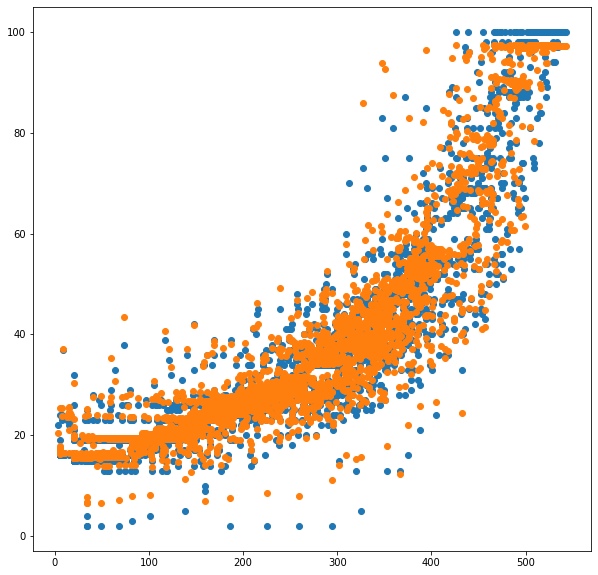

In [38]:
plt.figure(figsize=(10,10))
plt.scatter(original_x, original_y)
plt.scatter(original_x, pred_y)

In [488]:
from keras.models import save_model

save_model(model, "best_model_ever.h5")